# Experiment Analysis

In [1]:
# Imports:

import os
import sys

sys.path.append(os.path.join("..", "code"))

from experiment_analysis import *

In [2]:
exp_analysis = ExperimentAnalysis()

In [3]:
exp_analysis.experiments

,dec_dense_dim,dec_embed_dim,dec_num_heads,dem_kernal,dem_strides,dropout,enc_dense_dim,enc_embed_dim,enc_num_heads,end_time,...,use_masks,val_pred_end_time,val_pred_start_time,y_col,num_training_samples,architecture,pooling,cnn_activation,kernal,strides
id,,,,,,,,,,,,,,,,,,,,,
85818ee5-259e-4ed3-99ff-54a0d39adf2d,48,24,4,"(5, 5)","(1, 1)",0.5,48,24,4,2022-11-23 20:37:28,...,True,2022-11-23 20:35:45,2022-11-23 20:34:08,m3,NaN,NaN,NaN,NaN,NaN,NaN
1c69a2cc-dc5d-4983-a6e3-af22b7c6a0d8,48,24,4,"(5, 5)","(1, 1)",0.5,48,24,4,2022-11-23 19:09:41,...,True,2022-11-23 19:08:08,2022-11-23 19:06:44,m3,NaN,NaN,NaN,NaN,NaN,NaN
8eb5dcb4-a469-4868-aeb5-0d388100e461,64,24,4,"(5, 5)","(1, 1)",0.5,64,24,4,2022-11-23 17:26:50,...,True,2022-11-23 17:25:06,2022-11-23 17:23:32,m3,NaN,NaN,NaN,NaN,NaN,NaN
3880dd61-90b4-4d94-98e0-ee9aa5e29ee2,32,32,4,"(5, 5)","(1, 1)",0.5,32,32,4,2022-11-23 15:48:32,...,True,2022-11-23 15:46:42,2022-11-23 15:45:03,m3,NaN,NaN,NaN,NaN,NaN,NaN
f8804858-d98a-4207-8f0f-ef9707f1c7cd,32,16,2,"(5, 5)","(1, 1)",0.5,32,16,2,2022-11-22 23:36:32,...,True,2022-11-22 23:36:24,2022-11-22 23:35:57,m3,1742,NaN,NaN,NaN,NaN,NaN
c53eadc8-b9fe-4270-98b9-0cf13707f024,48,24,4,"(5, 5)","(1, 1)",0.5,48,24,4,2022-11-23 21:06:09,...,True,2022-11-23 21:05:02,2022-11-23 21:04:03,m3,NaN,NaN,NaN,NaN,NaN,NaN
4bfdd905-b9d8-4edc-8554-95ff4b6c9c79,32,16,2,"(5, 5)","(1, 1)",0.5,32,16,2,2022-11-23 04:20:08,...,True,2022-11-23 04:18:35,2022-11-23 04:17:06,m3,NaN,NaN,NaN,NaN,NaN,NaN
4d643901-3703-4eab-97d6-2efc59282a1e,48,24,4,"(5, 5)","(1, 1)",0.5,48,24,4,2022-11-23 19:52:03,...,True,2022-11-23 19:50:32,2022-11-23 19:49:07,m3,NaN,NaN,NaN,NaN,NaN,NaN
d2907972-e52e-45c2-a97e-d7a5536986bf,32,16,4,"(5, 5)","(1, 1)",0.5,32,16,4,2022-11-23 05:18:49,...,True,2022-11-23 05:16:15,2022-11-23 05:13:53,m3,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
experiment_id = "d794a258-f6f2-4dbc-a1a8-b726e9047ae7"

In [5]:
merged = exp_analysis.merge_pred_and_truth(experiment_id)

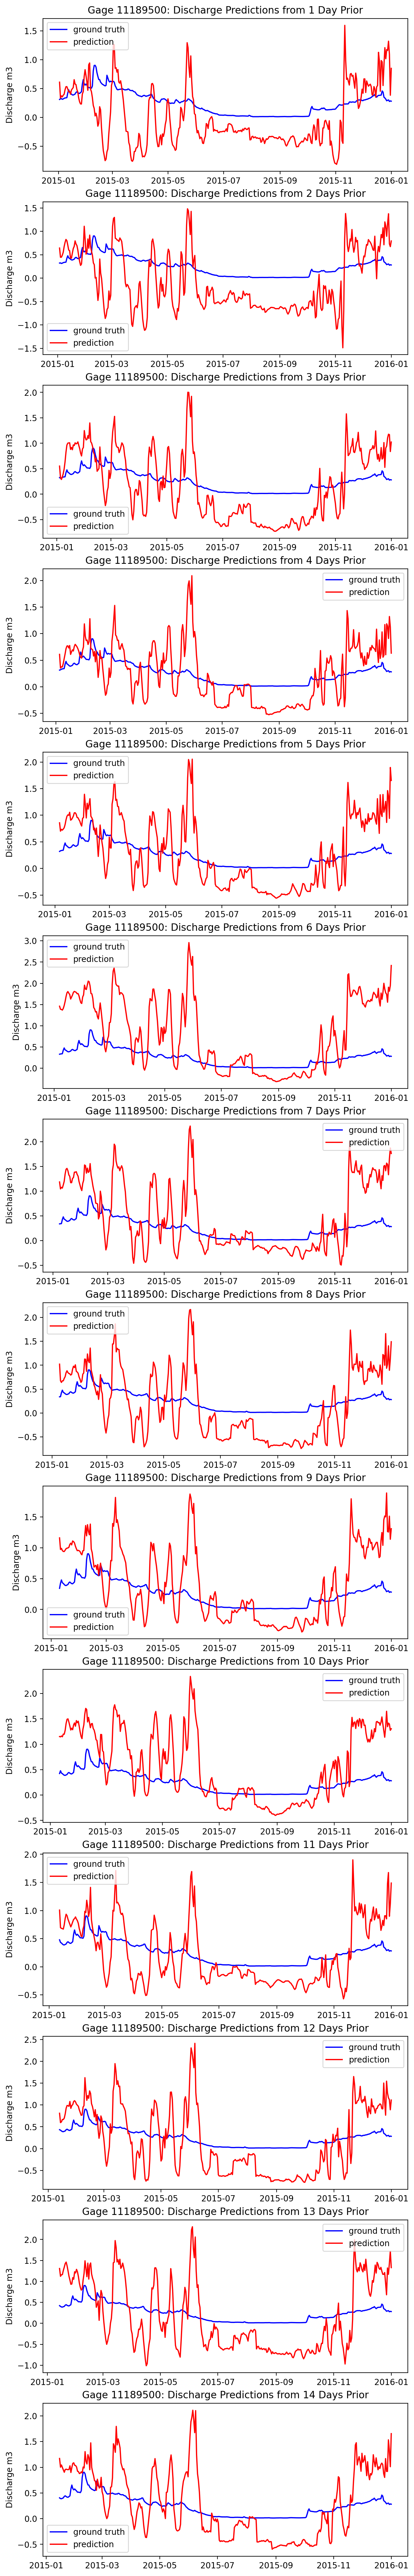

In [6]:
exp_analysis.plot_pred_vs_true(merged, "11189500", days=list(range(1, 15, 1)))

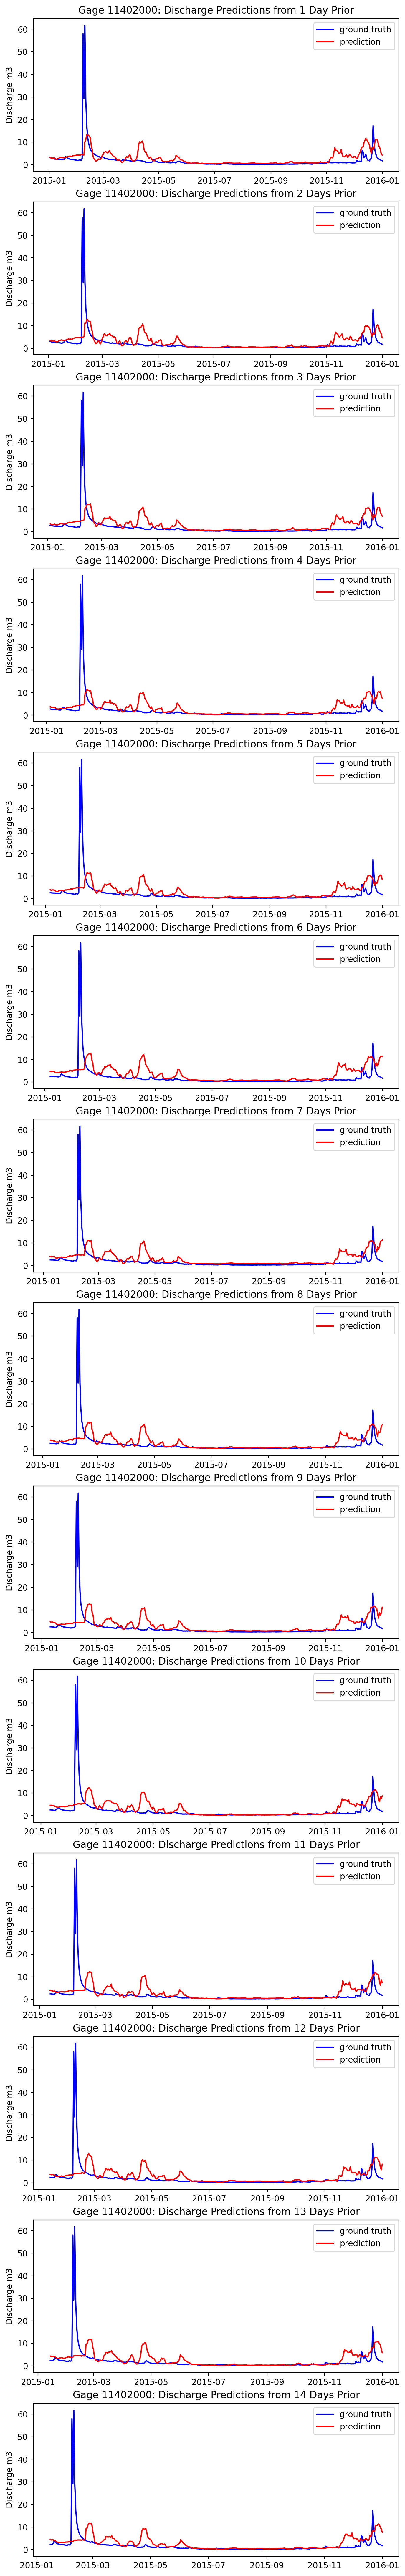

In [7]:
exp_analysis.plot_pred_vs_true(merged, "11402000", days=list(range(1, 15, 1)))

In [8]:
rmse_results = exp_analysis.compute_rmse_results()

Results saved to:
  /tf/toby/discharge-estimation/experiments/rmse_results.csv


In [9]:
two_gage_results = rmse_results[rmse_results["gages"] == "['11402000', '11189500']"]
two_gage_results

,id,gages,epochs,hidden_dim,enc_num_heads,dec_num_heads,n_days_et,n_days_precip,n_days_temp,n_days_y,...,rmse_7day,rmse_8day,rmse_9day,rmse_10day,rmse_11day,rmse_12day,rmse_13day,rmse_14day,rmse_avg,rmse_total
22,b355535f-6a36-4696-bd0b-2996fc0664b5,"['11402000', '11189500']",2,24,4,4,8,1,21,14,...,3.489142,3.507619,3.513476,3.485724,3.486016,3.506417,3.512438,3.530276,3.474860,3.475416
19,917bfa66-7b2b-425e-a9df-c78a9dfc9797,"['11402000', '11189500']",2,24,4,4,8,1,28,14,...,3.548867,3.547132,3.618931,3.565395,3.472436,3.452204,3.512325,3.489482,3.506474,3.507867
0,85818ee5-259e-4ed3-99ff-54a0d39adf2d,"['11402000', '11189500']",2,24,4,4,8,1,14,14,...,3.686990,3.620301,3.604723,3.620011,3.552958,3.522440,3.561905,3.569105,3.560279,3.561391
7,4d643901-3703-4eab-97d6-2efc59282a1e,"['11402000', '11189500']",2,24,4,4,8,1,7,14,...,3.659169,3.686276,3.704252,3.717577,3.610941,3.658156,3.647242,3.638664,3.618724,3.619778
23,e22ab74a-6abb-4962-aee1-63a8796e9953,"['11402000', '11189500']",2,24,4,4,32,7,7,14,...,3.748031,3.677609,3.698012,3.772461,3.723211,3.706322,3.732543,3.767212,3.654247,3.656389
1,1c69a2cc-dc5d-4983-a6e3-af22b7c6a0d8,"['11402000', '11189500']",2,24,4,4,8,2,7,14,...,3.726989,3.770039,3.770748,3.760548,3.690274,3.759965,3.733288,3.685596,3.673780,3.675304
12,8aff7f26-967a-4232-b9ac-1c0fdd9a69c4,"['11402000', '11189500']",2,24,4,4,8,3,7,14,...,3.714990,3.723769,3.707002,3.688149,3.674040,3.786015,3.737664,3.711714,3.676860,3.678139
16,8e7acd04-89bc-402c-9a5c-29d4ca04e579,"['11402000', '11189500']",2,24,4,4,8,7,7,14,...,3.727704,3.688646,3.759211,3.779930,3.760535,3.743770,3.759614,3.753196,3.676298,3.678274
25,667ba533-1618-4bee-aec4-736d9927e1c5,"['11402000', '11189500']",10,24,4,4,8,1,21,14,...,3.683642,3.707201,3.699086,3.721098,3.672340,3.711409,3.756751,3.771260,3.682004,3.682358
18,8d8e23ce-e5b0-4205-b958-6f5e3e513d00,"['11402000', '11189500']",2,24,4,4,8,7,7,14,...,3.750406,3.687988,3.797046,3.827948,3.721247,3.739065,3.791332,3.806916,3.682788,3.685015


In [10]:
two_gage_results.iloc[0]

id               b355535f-6a36-4696-bd0b-2996fc0664b5
gages                        ['11402000', '11189500']
epochs                                              2
hidden_dim                                         24
enc_num_heads                                       4
                                 ...                 
rmse_12day                                   3.506417
rmse_13day                                   3.512438
rmse_14day                                   3.530276
rmse_avg                                      3.47486
rmse_total                                   3.475416
Name: 22, Length: 65, dtype: object

#### Clearup

In [11]:
bad_experiments = exp_analysis.cleanup_bad_experiments()
bad_experiments

10 bad experiments contain some files so not deleted:
['2d594519-15dd-464d-86e7-f6d5cee8053f', '3e9de5e8-b03e-4ba5-a0e5-10fc724abb9c', '3f260e4c-2d89-41b1-8f52-ec5282245b89', '40176a1f-8f1c-4b06-aa20-9ca26dd4aed4', '6dda2748-243a-411f-8a17-81a6065177eb', '95ad1867-3ab7-4f95-9da1-bdbacf9c6a8c', 'af714861-f0ab-421c-b618-6fdb702d6b0b', 'dff2c35e-0bf9-4d8f-b760-2744329dc8a2', 'fac79eaa-08db-45af-822b-f65fdc27745d', 'ffa0f84f-1091-4b4c-bde6-b537168fb680']


['95ad1867-3ab7-4f95-9da1-bdbacf9c6a8c',
 'fac79eaa-08db-45af-822b-f65fdc27745d',
 'ffa0f84f-1091-4b4c-bde6-b537168fb680',
 '3f260e4c-2d89-41b1-8f52-ec5282245b89',
 'dff2c35e-0bf9-4d8f-b760-2744329dc8a2',
 'af714861-f0ab-421c-b618-6fdb702d6b0b',
 '6dda2748-243a-411f-8a17-81a6065177eb',
 '3e9de5e8-b03e-4ba5-a0e5-10fc724abb9c',
 '40176a1f-8f1c-4b06-aa20-9ca26dd4aed4',
 '2d594519-15dd-464d-86e7-f6d5cee8053f']